# 3D CNN

Basic + Augmentations (invert, rotate, zoom, blur, noise)

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import plot_training_history, show_simple_metrics, show_metrics

In [2]:
import tensorflow as tf

RANDOM_SEED = 792379571013149
tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
Num GPUs Available:  1


## Setup

In [3]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False
    
class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq
    
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20201215-174643
Wall time: 5 ms


In [4]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
#     'l2_beta': 0.0005,
#     'l2_beta': None,
#     'dropout': 0.10,
#     'dropout': None,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': False,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00025,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 200,
    'patience': 25,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0.2, 0.015),
        'shear': (0, 2.5), # probability, degrees
        'blur': (0.2, 0.8),
        'noise': (0.2, 0.00025)
    },
    'batch_size': 10,
#     'model_checkpoint_callback': False,
}

## Train

In [5]:
model = create_model(**model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 64, 52, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 17, 21, 17, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 17, 21, 17, 128)   221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 4, 5, 4, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 10240)             0

In [6]:
# load_checkpoint(model, DEFAULT_CHECKPOINT_DIRECTORY_LOCAL, '20201213-182225', 'cp-0002.ckpt')

In [7]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


In [8]:
%%time

model, checkpoint_dir, history = train(
    model,
    train_seq,
    test_seq,
    CHECKPOINT_DIRECTORY,
    LOG_DIRECTORY,
    DATA_DIR,
    **train_config
)

model key: 20201215-174643
checkpoint dir: ../../tmp\checkpoints\20201215-174643
log dir: ../../tmp\logs\20201215-174643
loading ../../tmp\data-v3\train_x.npy, ../../tmp\data-v3\train_y.npy...
loading ../../tmp\data-v3\val_x.npy, ../../tmp\data-v3\val_y.npy...
training...
Epoch 1/200
41/41 [==============================] - ETA: 0s - loss: 0.7385 - recall: 0.4179 - precision: 0.4179 - auc: 0.4239 - categorical_accuracy: 0.4179
Epoch 00001: val_auc improved from -inf to 0.43300, saving model to ../../tmp\checkpoints\20201215-174643\cp-0001.ckpt
41/41 [==============================] - 16s 387ms/step - loss: 0.7385 - recall: 0.4179 - precision: 0.4179 - auc: 0.4239 - categorical_accuracy: 0.4179 - val_loss: 0.7112 - val_recall: 0.3800 - val_precision: 0.3800 - val_auc: 0.4330 - val_categorical_accuracy: 0.3800
Epoch 2/200
41/41 [==============================] - ETA: 0s - loss: 0.7032 - recall: 0.4925 - precision: 0.4925 - auc: 0.4786 - categorical_accuracy: 0.4925
Epoch 00002: val_auc i

Epoch 17/200
41/41 [==============================] - ETA: 0s - loss: 0.6534 - recall: 0.6219 - precision: 0.6219 - auc: 0.6607 - categorical_accuracy: 0.6219
Epoch 00017: val_auc did not improve from 0.48790
41/41 [==============================] - 14s 346ms/step - loss: 0.6534 - recall: 0.6219 - precision: 0.6219 - auc: 0.6607 - categorical_accuracy: 0.6219 - val_loss: 0.6840 - val_recall: 0.4300 - val_precision: 0.4300 - val_auc: 0.4798 - val_categorical_accuracy: 0.4300
Epoch 18/200
41/41 [==============================] - ETA: 0s - loss: 0.6489 - recall: 0.6219 - precision: 0.6219 - auc: 0.6603 - categorical_accuracy: 0.6219
Epoch 00018: val_auc improved from 0.48790 to 0.50790, saving model to ../../tmp\checkpoints\20201215-174643\cp-0018.ckpt
41/41 [==============================] - 14s 351ms/step - loss: 0.6489 - recall: 0.6219 - precision: 0.6219 - auc: 0.6603 - categorical_accuracy: 0.6219 - val_loss: 0.6789 - val_recall: 0.4400 - val_precision: 0.4400 - val_auc: 0.5079 - val

Epoch 33/200
41/41 [==============================] - ETA: 0s - loss: 0.4942 - recall: 0.7736 - precision: 0.7736 - auc: 0.8520 - categorical_accuracy: 0.7736
Epoch 00033: val_auc improved from 0.63345 to 0.64805, saving model to ../../tmp\checkpoints\20201215-174643\cp-0033.ckpt
41/41 [==============================] - 15s 355ms/step - loss: 0.4942 - recall: 0.7736 - precision: 0.7736 - auc: 0.8520 - categorical_accuracy: 0.7736 - val_loss: 0.6328 - val_recall: 0.5800 - val_precision: 0.5800 - val_auc: 0.6481 - val_categorical_accuracy: 0.5800
Epoch 34/200
41/41 [==============================] - ETA: 0s - loss: 0.4983 - recall: 0.7711 - precision: 0.7711 - auc: 0.8472 - categorical_accuracy: 0.7711
Epoch 00034: val_auc improved from 0.64805 to 0.66910, saving model to ../../tmp\checkpoints\20201215-174643\cp-0034.ckpt
41/41 [==============================] - 14s 353ms/step - loss: 0.4983 - recall: 0.7711 - precision: 0.7711 - auc: 0.8472 - categorical_accuracy: 0.7711 - val_loss: 0.6

Epoch 48/200
41/41 [==============================] - ETA: 0s - loss: 0.3954 - recall: 0.8333 - precision: 0.8333 - auc: 0.9231 - categorical_accuracy: 0.8333
Epoch 00048: val_auc improved from 0.76870 to 0.76960, saving model to ../../tmp\checkpoints\20201215-174643\cp-0048.ckpt
41/41 [==============================] - 15s 358ms/step - loss: 0.3954 - recall: 0.8333 - precision: 0.8333 - auc: 0.9231 - categorical_accuracy: 0.8333 - val_loss: 0.5927 - val_recall: 0.7300 - val_precision: 0.7300 - val_auc: 0.7696 - val_categorical_accuracy: 0.7300
Epoch 49/200
41/41 [==============================] - ETA: 0s - loss: 0.3912 - recall: 0.8383 - precision: 0.8383 - auc: 0.9225 - categorical_accuracy: 0.8383
Epoch 00049: val_auc improved from 0.76960 to 0.77390, saving model to ../../tmp\checkpoints\20201215-174643\cp-0049.ckpt
41/41 [==============================] - 15s 358ms/step - loss: 0.3912 - recall: 0.8383 - precision: 0.8383 - auc: 0.9225 - categorical_accuracy: 0.8383 - val_loss: 0.5

Epoch 64/200
41/41 [==============================] - ETA: 0s - loss: 0.3508 - recall: 0.8607 - precision: 0.8607 - auc: 0.9449 - categorical_accuracy: 0.8607
Epoch 00064: val_auc did not improve from 0.78010
41/41 [==============================] - 15s 357ms/step - loss: 0.3508 - recall: 0.8607 - precision: 0.8607 - auc: 0.9449 - categorical_accuracy: 0.8607 - val_loss: 0.5895 - val_recall: 0.7600 - val_precision: 0.7600 - val_auc: 0.7795 - val_categorical_accuracy: 0.7600
Epoch 65/200
41/41 [==============================] - ETA: 0s - loss: 0.3578 - recall: 0.8582 - precision: 0.8582 - auc: 0.9383 - categorical_accuracy: 0.8582
Epoch 00065: val_auc improved from 0.78010 to 0.78060, saving model to ../../tmp\checkpoints\20201215-174643\cp-0065.ckpt
41/41 [==============================] - 15s 360ms/step - loss: 0.3578 - recall: 0.8582 - precision: 0.8582 - auc: 0.9383 - categorical_accuracy: 0.8582 - val_loss: 0.5900 - val_recall: 0.7600 - val_precision: 0.7600 - val_auc: 0.7806 - val

Epoch 81/200
41/41 [==============================] - ETA: 0s - loss: 0.3301 - recall: 0.8856 - precision: 0.8856 - auc: 0.9567 - categorical_accuracy: 0.8856
Epoch 00081: val_auc did not improve from 0.78065
41/41 [==============================] - 15s 358ms/step - loss: 0.3301 - recall: 0.8856 - precision: 0.8856 - auc: 0.9567 - categorical_accuracy: 0.8856 - val_loss: 0.5897 - val_recall: 0.7600 - val_precision: 0.7600 - val_auc: 0.7802 - val_categorical_accuracy: 0.7600
Epoch 82/200
41/41 [==============================] - ETA: 0s - loss: 0.3289 - recall: 0.8806 - precision: 0.8806 - auc: 0.9545 - categorical_accuracy: 0.8806
Epoch 00082: val_auc did not improve from 0.78065
41/41 [==============================] - 14s 353ms/step - loss: 0.3289 - recall: 0.8806 - precision: 0.8806 - auc: 0.9545 - categorical_accuracy: 0.8806 - val_loss: 0.5900 - val_recall: 0.7600 - val_precision: 0.7600 - val_auc: 0.7800 - val_categorical_accuracy: 0.7600
Epoch 83/200
41/41 [======================

41/41 [==============================] - ETA: 0s - loss: 0.3344 - recall: 0.8731 - precision: 0.8731 - auc: 0.9503 - categorical_accuracy: 0.8731
Epoch 00098: val_auc did not improve from 0.78065
41/41 [==============================] - 14s 352ms/step - loss: 0.3344 - recall: 0.8731 - precision: 0.8731 - auc: 0.9503 - categorical_accuracy: 0.8731 - val_loss: 0.5898 - val_recall: 0.7600 - val_precision: 0.7600 - val_auc: 0.7794 - val_categorical_accuracy: 0.7600
Wall time: 26min 49s


## Evaluation

Wall time: 135 ms


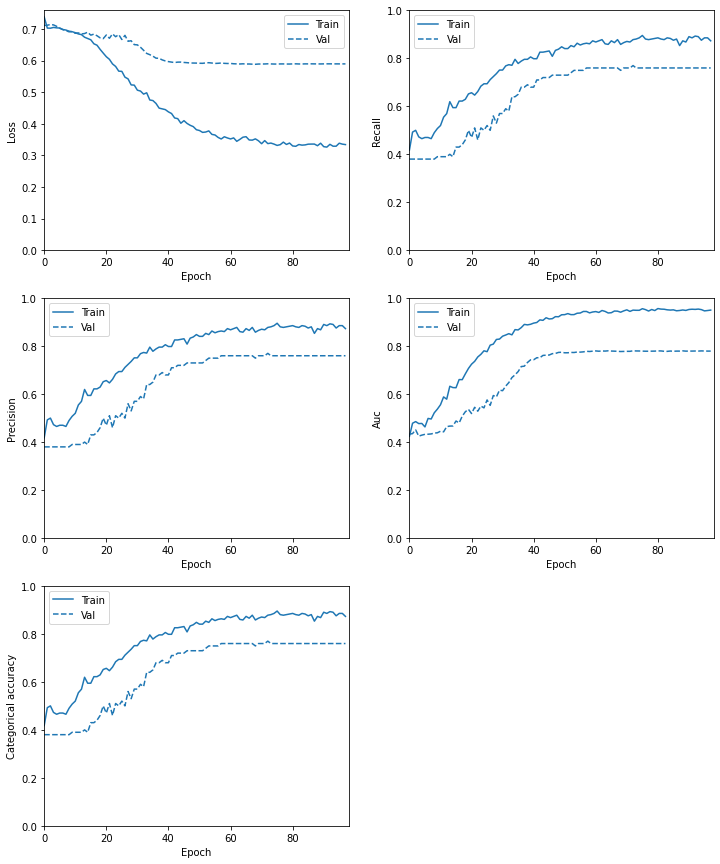

In [9]:
%%time

plot_training_history(history)

In [10]:
%%time

show_simple_metrics(model, test_seq)

loss: 0.5725356936454773
recall: 0.7699999809265137
precision: 0.7699999809265137
auc: 0.7806499600410461
categorical_accuracy: 0.7699999809265137

Wall time: 23.8 s


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.8095238095238095
recall: 0.8225806451612904
f1-score: 0.8160000000000001
support: 62


CN
precision: 0.7027027027027027
recall: 0.6842105263157895
f1-score: 0.6933333333333334
support: 38


micro avg
precision: 0.77
recall: 0.77
f1-score: 0.7699999999999999
support: 100


macro avg
precision: 0.7561132561132562
recall: 0.7533955857385399
f1-score: 0.7546666666666667
support: 100


weighted avg
precision: 0.768931788931789
recall: 0.77
f1-score: 0.7693866666666668
support: 100


samples avg
precision: 0.77
recall: 0.77
f1-score: 0.77
support: 100


F1
micro: 0.7699999999999999
macro: 0.7546666666666667


accuracy_score: 0.77
sensitivity_score: 0.8225806451612904
specificity_score: 0.6842105263157895


Wall time: 22 s


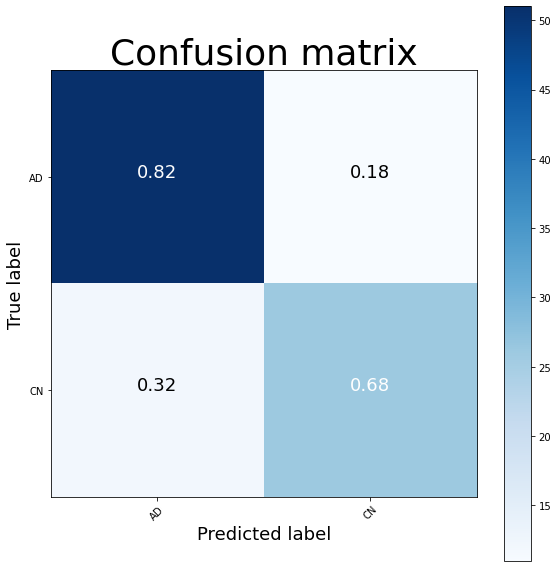

In [11]:
%%time

show_metrics(model, test_seq, class_names)